# Goal

### Determine which products are the same using product image and title.

In [ ]:
import os
import pandas as pd
data_dir = '../input/shopee-product-matching'
df = pd.read_csv(f'{data_dir}/train.csv')
df.head()

In [ ]:
import cv2
import matplotlib.pyplot as plt

def image_viz(image_path, title, ax):
    """
    Function for visualization.
    Takes path to image as input.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    ax.imshow(img)
    #plt.axis('off')
    ax.set_title(title)
    
train_img_dir = '../input/shopee-product-matching/train_images'
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    image_path = '{}/{}'.format(train_img_dir, df.iloc[i]['image'])
    image_title = df.iloc[i]['title']
    image_viz(image_path, image_title, ax)

# Image similarity
<ul>
<li style="font-size:20px">Phash</li>
<li style="font-size:20px">Embedding from the pretrained neural network</li>
<li style="font-size:20px">ArcFace, CosFace and some other modifications of NN</li>
<li style="font-size:15px">Image preprocessing (optional)</li>
</ul>

# Phash

This algorithm shrinks the image to 8x8 pixels, converts it to grayscale, calculates the mean, and uses the mean as a threshold to compute a bit for each pixel.
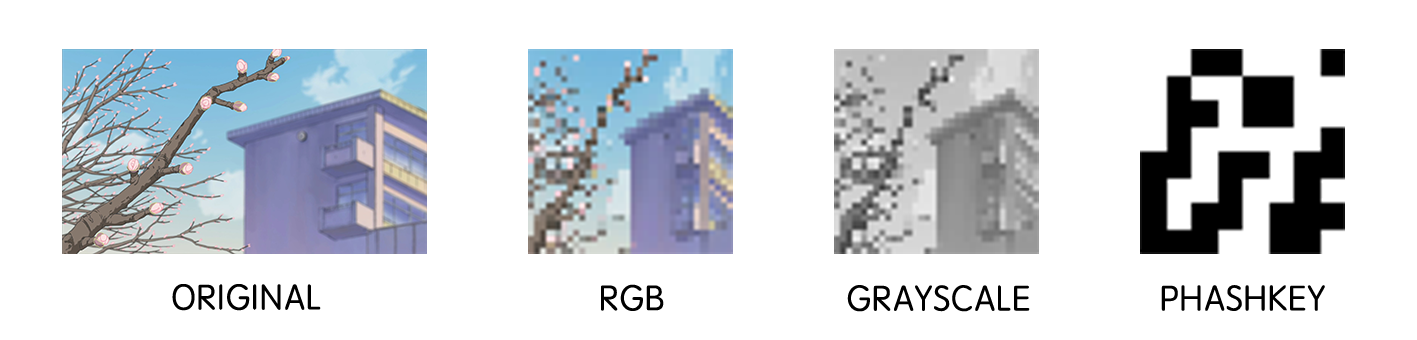
<center><i>Illustration, source: https://blog.windisco.com/animeloop-paper-en/</i></center>

**Phash** matrix can be flattened into a vector and similarity between images can be measured by **Hamming distance**. Hamming distance between vectors $u$ and $v$ is the number of positions at which vector elements are different. Example
* hamming([1,0,0], [1,0,0]) = 0
* hamming([1,0,1], [0,1,0]) = 3.

More about phash https://www.kaggle.com/maksymshkliarevskyi/shopee-before-we-start-eda-phash-baseline

In order to compute Hamming distance for each image with all others, using only two nested loops can be computationally expensive with the time complexity of $\mathcal{O}(n^{2})$. This can be reduced to $\mathcal{O}(n\log n)$ using **BKTree** or any other appropriate tree data structure. Practically, it runs even faster if the goal is to find kNN, where $k$ depends on smaller Hamming distance. The approach is detailed described here https://www.kaggle.com/eneszvo/clean-wrong-labels-speed-up-with-bktree  


# Embedding

We can think of **embedding** as a part of a neural network that we can extract and use as an image representation. Basically, it is a vector that describes the position of the particular image in the embedding space. If the embedding vector has 3 components, it means that the embedding space is 3D. Some examples are presented here https://www.kaggle.com/c/shopee-product-matching/discussion/226279

In order to extract the embedding, we don't need to build and train our own CNN from scratch. We can use **pre-trained CNN** architecture such as ResNet, Inception, EfficientNet, or any other. Particularly, in this competition mostly is used **EfficientNetB0 - B7** (where B7 is the most complex with the most parameters). EfficientNet is known as a method that systematically scales the depth, width, and resolution of CNN. Example of EfficientNetB0 using Keras https://www.kaggle.com/cdeotte/rapids-cuml-tfidfvectorizer-and-knn

**ResNet in pytorch** https://www.kaggle.com/finlay/unsupervised-image-text-baseline-in-20min

Pytorch image models (from **timm package**) https://www.kaggle.com/parthdhameliya77/pytorch-eca-nfnet-l0-image-tfidf-inference

**ArcFace DenseNet** https://www.kaggle.com/underwearfitting/pytorch-densenet-arcface-validation-training

**Siamese ResNet-50 from Keras** https://www.kaggle.com/xhlulu/shopee-siamese-resnet-50-with-triplet-loss-on-tpu

Light weight NN useful for mobile and embedded vision applications, **MobileNet**, from simple and easy to use package **imagededup** https://www.kaggle.com/heyytanay/finding-similar-images-using-image-deduplicator

After embeddings for all images are extracted, we can measure how similar they are using some of the distance metrics such as **Euclidean distance** or **cosine similarity**.

# ArcFace embedding

Modification that forces similar class embeddings to be closer and dissimilar more distant. The simple example with MNIST https://www.kaggle.com/slawekbiel/arcface-explained/.

Basically, it modifies the softmax loss function in order to achieve better separation for different classes in the embedding space. To understand the formula lets first recall cross-entropy loss and softmax definition.

**Cross-entropy loss** - measures the performance of a classification model whose output is a probability value between 0 and 1. Usually used for multi-class classification. 
$$CE = -\sum_{i=1}^{C} t_{i}\log(a_{i})$$
where $C$ is the number of classes, $t$ is mostly a one-hot vector (or binary vector for multi-label classification) representing labels, and $a$ activation function (usually the output function in the NN).

**Softmax function** - the activation function in the output layer of neural network models that predict a multinomial probability distribution.
$$ softmax(x_{i}) = \frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}$$
where $x$ is $n$-dimensional vector.

**Softmax loss** - cross-entropy loss applied on softmax activation function,
$$CE = -\sum_{i=1}^{C} t_{i}\log(a_{i}) = -\sum_{i=1}^{C} t_{i}\log(\frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}).$$

If $t=(t_{1}, t_{2},..., t_{C})$ is one-hot vector where $t_{i}=1$, then softmax loss becomes
$$CE = -\log(\frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}).$$

**Softmax cost** function is the average of the loss functions over the training set (or batch), 
$$CE = -\frac{1}{N}\sum_{i=1}^{N}\log(\frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}).$$
Based on the figure below,
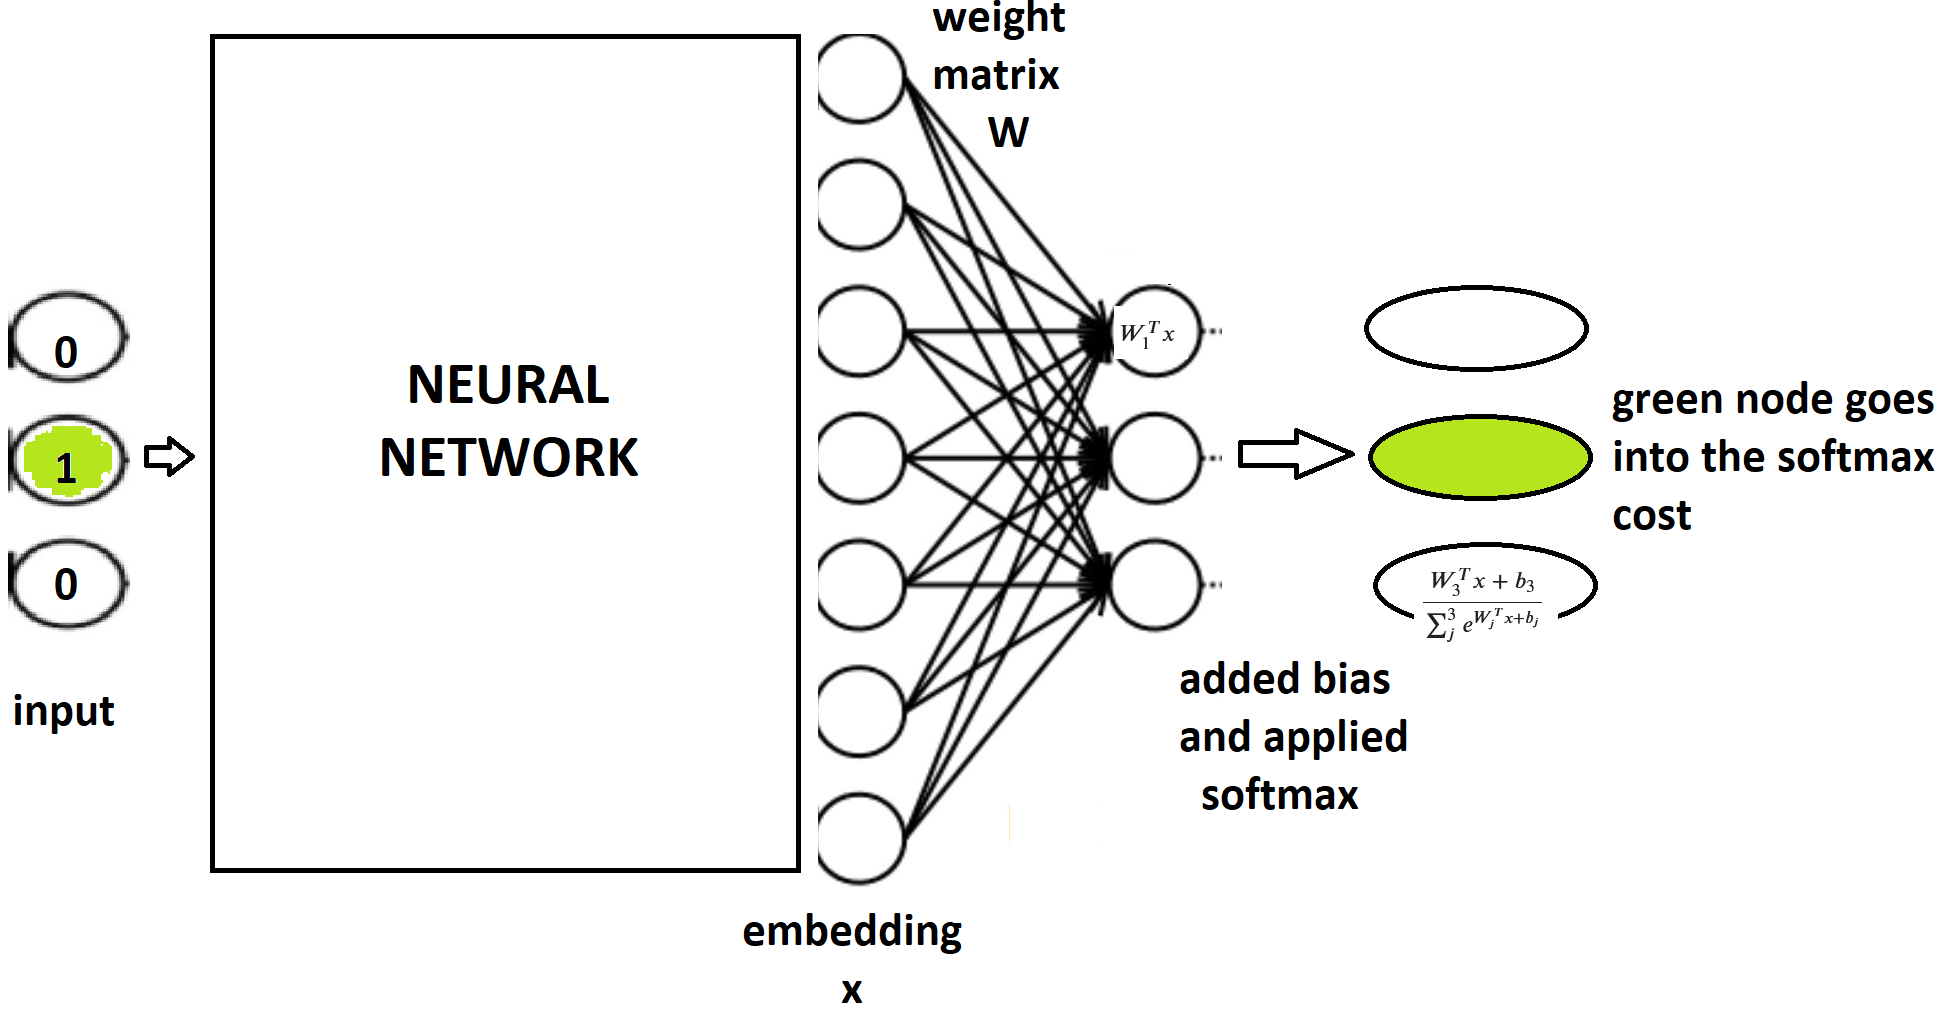
**softmax cost** can be written as
$$CE = -\frac{1}{N}\sum_{i}^{N}\log(\frac{e^{W_{y_{i}}^{T}x_{i} + b_{y_{i}}}}{\sum_{j=1}^{n} e^{W_{j}^{T}x_{i} + b_{j}}}).$$
where $x_{i}$ denotes embedding of the $i$-th sample, belonging to the $y_{i}$-th class (from the image above, $y_{i}=2$). $W_{j}$ denotes the $j$-th column of the weight matrix $W$.

Lets fix $b=\mathbf{0}$, normalize all weight columns $\Vert W_{j}\Vert=1$ and normalize embedding vector $\Vert x\Vert=1$. After normalization, embedding will be distributed on a unit hypersphere. Now we have that 
$$W_{j}^{T}x + b_{j}=\frac{W_{j}^{T}x}{\Vert W_{j}\Vert\Vert x\Vert} = \cos(\langle W_{j}^{T}, x\rangle)=\cos(\theta_{j}).$$

Further, we can easily get $\theta$ angle applying $\arccos$ to both sides and after increase $\theta$ by penalty $m$. From the ArcFace paper https://arxiv.org/pdf/1801.07698.pdf, autors explained it as:  
> We add an additive angular margin penalty $m$ between $x_{i}$ and $W_{y_{i}}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy.

After all, the softmax cost becomes 
$$CE = -\frac{1}{N}\sum_{i}^{N}\log(\frac{e^{s \cos(\theta_{y_{i}}+m)}}{e^{s \cos(\theta_{y_{i}}+m)} + \sum_{j=1, j\neq y_{i}}^{n} e^{s \cos(\theta_{j})}})$$
where $s$ is a scaler that defines the radius of hypersphere where embeddings are distributed. 

* The baseline with the EfficientNetb3 ArcFace model in **TensorFlow** https://www.kaggle.com/ragnar123/unsupervised-baseline-arcface
* EfficientNet b0-b7 + ArcFace/CosFace/AdaCos in **PyTorch** https://www.kaggle.com/tanulsingh077/pytorch-metric-learning-pipeline-only-images

## Image preprocessing

Before fitting images into any kind of model, it might be useful apply some of the preprocessing steps. Some of the techniques such as **brightness normalization, edge detection, HSV transform** can be found here https://www.kaggle.com/ishandutta/v7-shopee-indepth-eda-one-stop-for-all-your-needs

Also, using image transformations can be useful as data augumentation step for training set. In order to have more unbiased model, some random changing of the images can be applied, like **random flip, random contrast, random brightness** and similar. This is exactly what is applied here https://www.kaggle.com/ragnar123/shopee-efficientnetb3-arcmarginproduct

Four different **images hash** methods, as well as comparing **image histograms and key points** could fast provide reasonable results. https://www.kaggle.com/finlay/shopee-products-matching-image-part-english


# Text similarity
<ul>
<li style="font-size:20px">TF-IDF</li>
<li style="font-size:20px">Pretrained embedding</li>
<li style="font-size:15px">OCR</li>
</ul>

# TF-IDF

**TF-IDF** (term frequency-inverse document frequency) is a simple and meaningful method for converting text into numerical vectors. The size of the vector depends of vocabulary that is formed from input text, where each element in the vector represents the unique token (word) from the vocabulary. The value of the vector element is calculated using th formula $$TF(t)\cdot IDF(t),$$ where $TF(t)$ is number of times term $t$ appears in a document (sentence) and 
$$IDF(t) = \log \frac{1+n}{1+df(t)}+1,$$
where $n$ is the total number of documents (sentences) in the input (text corpus), and $df(t)$ is the number of documents (sentences) in the input that contain the term $t$. 

After sentences are converted into vectors, we can find similar ones using metrics like Euclidean distance or cosine similarity.

* TF-IDF from sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 
* TF-IDF cuML https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700


# Pretrained embedding

Similar to images, we can use pretrained neural network-based model in order to extract embeddings for sentences. One of the popular is for sure **BERT**.

Notebook with BERT model in TF https://www.kaggle.com/ragnar123/unsupervised-baseline-arcface

DistilBERT https://www.kaggle.com/moeinshariatnia/indonesian-distilbert-finetuning-with-arcmargin


## OCR 

**OCR** (optical character recognition) refers to the text extraction from the images. In this competition, there was some mention about OCR, but I'm not sure if someone found it useful. How to extract text from images is presented here https://www.kaggle.com/mohneesh7/shopee-challenge-eda-nlp-on-title-ocr